In [1]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_cars_drop_checkpoints_with_nms'

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [3]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
idd_data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"

kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val')

# Full datasets samples
kitti_train_samples = len(kitti_train_dataset)
kitti_val_samples = len(kitti_val_dataset)
idd_val_samples = len(idd_val_dataset)

# Subset Datasets
subset_kitti_train_samples = round(len(kitti_train_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_kitti_val_samples = round(len(kitti_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_idd_val_samples = round(len(idd_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)

SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

# Subset of full datasets
subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

In [4]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model

In [5]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11060017_0.7454640828611436  fasterrcnn_11061638_0.7497252402944325
fasterrcnn_11061427_0.7282598515502949  fasterrcnn_11061705_0.7526206908232453
fasterrcnn_11061454_0.733123502219126   fasterrcnn_11062316_0.7550167879591324
fasterrcnn_11061507_0.7394557961451338


In [6]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# Extract classifier features

In [7]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [8]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_detections = len(all_max_ious)
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    print("Total detections: %d" % (total_detections))
    print("Total false positives (< %.2f) IoU: %f%%" % (MIN_IOU_REQUIRED, float(total_false_positives)/float(total_detections)*100))
    

def read_features(save_file, feature_idx, start=0, end=None):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y


def read_scores(save_file, start=0, end=None):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y

# Extract classifier features

#### Kitti Train

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


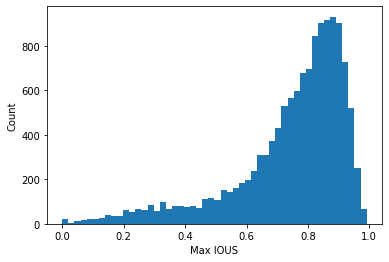

Total false positives (< 0.70) IoU: 3695
Total detections: 13115
Total false positives (< 0.70) IoU: 28.173847%


In [9]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val

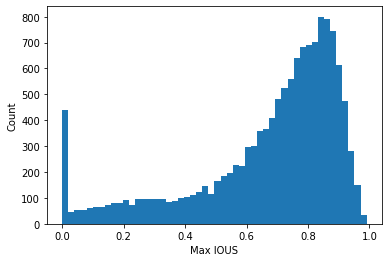

Total false positives (< 0.70) IoU: 5409
Total detections: 13424
Total false positives (< 0.70) IoU: 40.293504%


In [10]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

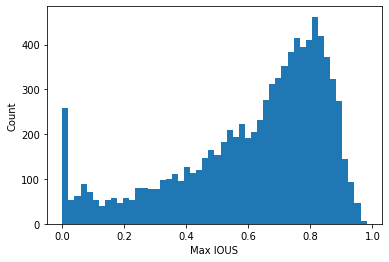

Total false positives (< 0.70) IoU: 4670
Total detections: 8878
Total false positives (< 0.70) IoU: 52.601937%


In [11]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

# Max Softmax

#### Kitti train

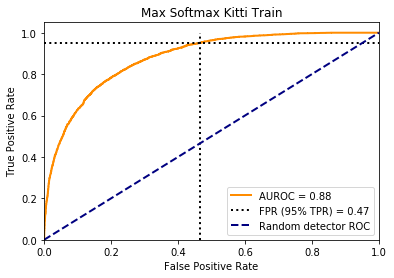

{'fpr_at_95_tpr': 0.46521508231545405, 'detection_error': 0.2570233669676049, 'auroc': 0.8792799156033357, 'aupr_in': 0.7488815379671073, 'aupr_out': 0.9480479255978359}


In [12]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_scores(save_path)

kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Max Softmax Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

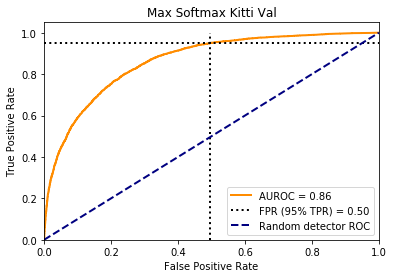

{'fpr_at_95_tpr': 0.496735308890005, 'detection_error': 0.2729281767955801, 'auroc': 0.8628160743492235, 'aupr_in': 0.8072416360709921, 'aupr_out': 0.8982402214760286}


In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Max Softmax Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

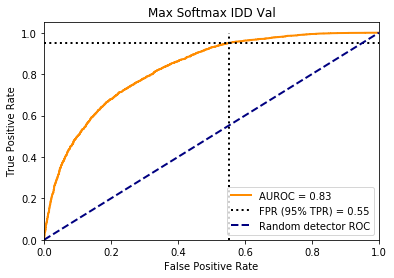

{'fpr_at_95_tpr': 0.5520428015564203, 'detection_error': 0.3009899278449328, 'auroc': 0.8274432905502824, 'aupr_in': 0.8312472708391049, 'aupr_out': 0.8198573114054868}


In [14]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Max Softmax IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## One-Class SVM on Kitti features (Conv-512 layer)

In [15]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 0)

In [16]:
kitti_train_X.shape

(13115, 512)

In [17]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    
if False:
    training_mask = kitti_train_y.astype(np.bool)

    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])
    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 9415 train samples of size 512


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


9


#### Kitti Train

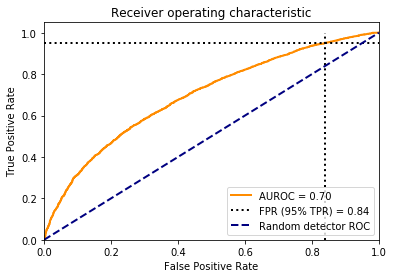

{'fpr_at_95_tpr': 0.8383783783783784, 'detection_error': 0.4441251740322372, 'auroc': 0.695085286561123, 'aupr_in': 0.8447931450621357, 'aupr_out': 0.4635103625137614}


In [18]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [19]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 0)

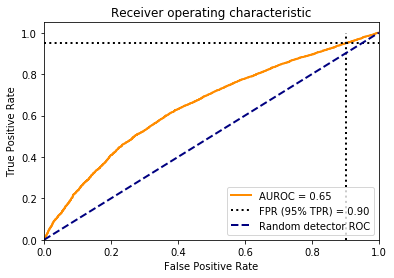

{'fpr_at_95_tpr': 0.9023809523809524, 'detection_error': 0.4761151371648609, 'auroc': 0.649722078106056, 'aupr_in': 0.7184586836487515, 'aupr_out': 0.5268878373760391}


In [20]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [21]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 0)

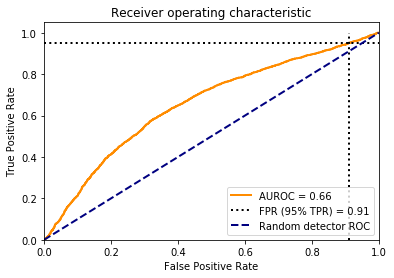

{'fpr_at_95_tpr': 0.9101972303818716, 'detection_error': 0.47987069155545686, 'auroc': 0.6553285951805183, 'aupr_in': 0.5920968392830612, 'aupr_out': 0.6548854492856121}


In [22]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [23]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 1)

In [24]:
kitti_train_X.shape

(13115, 4096)

In [25]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    
if False:
    training_mask = kitti_train_y.astype(np.bool)
    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)
    
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 9415 train samples of size 4096


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


10


#### Kitti Train

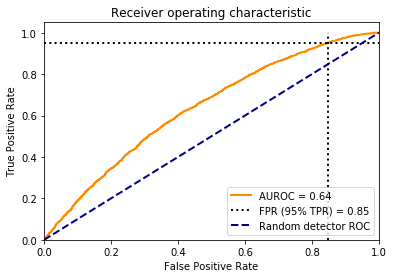

{'fpr_at_95_tpr': 0.847027027027027, 'detection_error': 0.44834328486744845, 'auroc': 0.6365381435604485, 'aupr_in': 0.7952949638456515, 'aupr_out': 0.43087713600278077}


In [26]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [27]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 1)

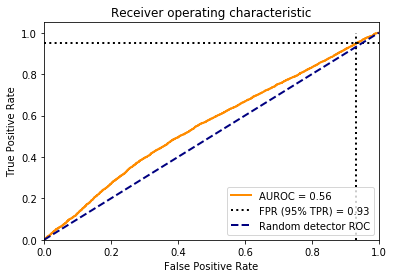

{'fpr_at_95_tpr': 0.9326007326007326, 'detection_error': 0.4912878097960971, 'auroc': 0.5556176558248381, 'aupr_in': 0.6362953958658948, 'aupr_out': 0.448662888434641}


In [28]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [29]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 1)

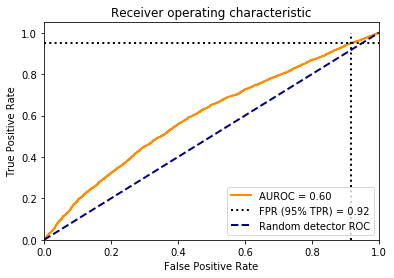

{'fpr_at_95_tpr': 0.9158623583718003, 'detection_error': 0.4827366266567173, 'auroc': 0.5991851275898836, 'aupr_in': 0.5515116657181967, 'aupr_out': 0.6089568514771728}


In [30]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

# Mahalanobis

#### Kitti train

In [31]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 4)

In [32]:
kitti_train_X.shape

(13115, 4096)

In [33]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")

if False:
    # Take features from good detections only
    kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]
    
    # Everything is labelled 0 because we're just doing single class detection
    kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))
    
    md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
    md.save(mahal_model_name)
    
else:
    md = Mahal_Dist.load(mahal_model_name)

Calculating mahal mean
Calculating mahal cov
Inverting


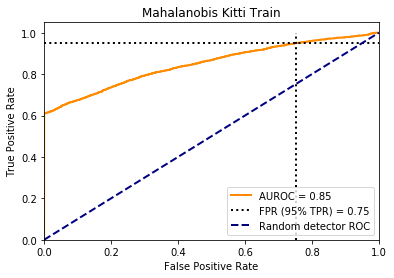

{'fpr_at_95_tpr': 0.7524163568773234, 'detection_error': 0.4006240042485396, 'auroc': 0.848975570897504, 'aupr_in': 0.8151110272401033, 'aupr_out': 0.9050715436658059}


In [35]:
# Chunked MD calc
l = len(kitti_train_X)
chunk = 10000
kitti_train_novelty_scores = [md(kitti_train_X[i:i+chunk]) for i in range(0,l,chunk)]
kitti_train_novelty_scores = np.concatenate(kitti_train_novelty_scores, axis=0)

# Non-chunked version for smaller datasets
# kitti_train_novelty_scores = md(kitti_train_X)

plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Mahalanobis Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

In [36]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 4)

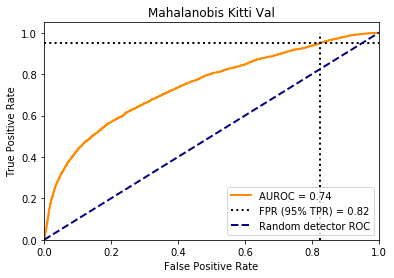

{'fpr_at_95_tpr': 0.8230788548468106, 'detection_error': 0.4364190597616012, 'auroc': 0.7443784346408656, 'aupr_in': 0.6849155333758286, 'aupr_out': 0.7831336884902416}


In [37]:
# Chunked MD calc
l = len(kitti_val_X)
chunk = 10000
kitti_val_novelty_scores = [md(kitti_val_X[i:i+chunk]) for i in range(0,l,chunk)]
kitti_val_novelty_scores = np.concatenate(kitti_val_novelty_scores, axis=0)

# Non-chunked version for smaller datasets
# kitti_val_novelty_scores = md(kitti_val_X)

plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

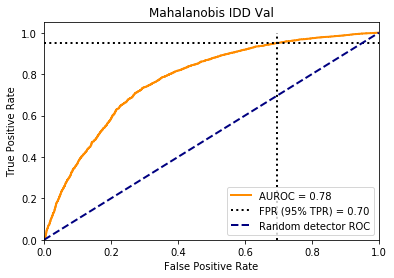

{'fpr_at_95_tpr': 0.6967412451361867, 'detection_error': 0.37325092541037275, 'auroc': 0.7759331510406887, 'aupr_in': 0.770086549180047, 'aupr_out': 0.7489053658605486}


In [38]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_y = []

# Chunked MD calc
with h5py.File(save_path, 'r') as f:
    l = (len(f))

chunk = 1000

idd_val_novelty_scores = []
for i in range(0, l, chunk):
    X, y = read_features(save_path, 4, i, i+chunk)
    idd_val_novelty_scores.append(md(X))
    idd_val_y.append(y)

idd_val_novelty_scores = np.concatenate(idd_val_novelty_scores, axis=0)
idd_val_y = np.concatenate(idd_val_y, axis=0)

# Non-chunked version for smaller datasets
# idd_val_novelty_scores = md(idd_val_X)

plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Mahalanobis IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## ODIN

### Find best params

In [39]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
# temperatures = np.array([1])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.linspace(0, 0.004, 5)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

In [40]:
results = []

trainer.faster_rcnn.eval()
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    if False:# and not os.path.exists(save_file):
        extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
    kitti_val_X, kitti_val_y = read_scores(save_file)
    kitti_val_novelty_scores = -kitti_val_X
    results.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)



ODIN Kitti Val e=0.000000, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, st

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/l

  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PaletteFile.py", line 23, in <module>
    class PaletteFile(object):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  Fi

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'f8944c2b-e263a0e67be411d5180c71fd', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 1, 44, 11, 497001, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'f8944c2b-e263a0e67be411d5180c71fd', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.t


ODIN Kitti Val e=0.000200, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
BrokenPipeEr

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoade

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/pro

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 103

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '6c50763e-a41e25f4e3107280d546468c', 'msg_type': 'co


ODIN Kitti Val e=0.000400, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Call stack:


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
   

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home

  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/dat

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen imp

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykerne

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GimpPaletteFile.py", line 25, in <module>
    class GimpPaletteFile(object):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/


ODIN Kitti Val e=0.000600, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---


--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/an

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyth

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/sit

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/t

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, i

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.

  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/env

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multipro

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, i

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GimpGradientFile.py", line 104, in <module>
    class GimpGradientFile(GradientFile):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anacond

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/t


ODIN Kitti Val e=0.000800, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    s

Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
  

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(Z

  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batch

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'a028a79a-697af75226d085ef3f4ae2f2', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 1, 52, 59, 2040, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'a028a79a-697af75226d085ef3f4ae2f2', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 396.12it/s]'}, 'buffer_paths': []}, 'comm_id': 'f4c4d267808446d7b18980b7a75ac155'}, 'metadata': {}}



ODIN Kitti Val e=0.001000, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
--- Logging error ---
--- Logging error ---
Call stack:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py"

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", lin

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  F

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/ana

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    r

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Pop

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap_external>", line 857, in g

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)



ODIN Kitti Val e=0.001200, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/si

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitt

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<ipython-input-8-d85452

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(proc

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/Git/simple-fa

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/n

Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '5233c5c1-c73b007ca895f245f318f87a', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 1, 57, 21, 673448, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '5233c5c1-c73b007ca895f245f318f87a', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 366.93it/s]'}, 'buffer_paths': []}, 'comm_id': 'd58320ef56eb41beb3bdd34caacd496f'}, 'metadata': {}}



ODIN Kitti Val e=0.001400, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "<ipython-input-40-d65e51dba9ee>", lin

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(proce

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImageSequence.py", line 19, in <module>
    class Iterator(object):
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<froze

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _not

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pack

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.


ODIN Kitti Val e=0.001600, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Brok

Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in f

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, i

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/hom

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 2

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=res

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '7c1f4cc8-f0cde927ffeb26a79809d2fc', 'msg_type': 'comm_msg', 'username': 'tadenou

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenou


ODIN Kitti Val e=0.001800, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
Call stack:
Traceback (most recent call l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anacond

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_his

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/l

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap_external>", li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_valu

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '7a444085-b6e7ee0a281989b25fb9789e', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 3, 54, 429051, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '7a444085-b6e7ee0a281989b25fb9789e', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'f4243b04-af2a012bb8a5b8b3d9573bd8', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 3, 54, 422113, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'f4243b04-af2a012bb8a5b8b3d9573bd8', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 398.70it/s]'}, 'buffer_paths': []}, 'comm_id': '46d627733c704ac38226cb9fd07ac04f'}, 'metadata': {}}
  File "/h


ODIN Kitti Val e=0.002000, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pi

BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
Call stack:
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: s

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expres

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Po

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.us

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py",

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='succe

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap_ex

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '39c44dea-9d8dcb5b29e98e42f603df1e', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 6, 6, 352795, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '39c44dea-9d8dcb5b29e98e42f603df1e', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'ver


ODIN Kitti Val e=0.002200, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 100

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyth

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = call

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packa

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenou

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pack

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._not


ODIN Kitti Val e=0.002400, T=1000


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadeno

  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'acd3e0ae-6300b513391a66aaed32043f', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2


ODIN Kitti Val e=0.002600, T=1000


--- Logging error ---


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packag

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, 

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py"

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", 

  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 983, 

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/t

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '7af0147e-224b85bb5cf9d41e0acf83c3', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 12, 43, 177520, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '7af0147e-224b85bb5cf9d41e0acf83c3', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 534.97it

Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '506a6c99-ba3a1b553273f5a79ef8bccd', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 12, 43, 173219, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '506a6c99-ba3a1b553273f5a79ef8bccd', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 537.08it/s]'}, 'buffer_paths': []}, 'comm_id': '83f4efe9348f4f86a4147f23cb8cec4a'}, 'metadata': {}}
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult

  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/trait


ODIN Kitti Val e=0.002800, T=1000



ODIN Kitti Val e=0.003000, T=1000


--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush(

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/taden

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/mu

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/I

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pa

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'f4fbebc3-507b235c0c59bdfa0ea98582', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 17, 8, 293907, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'f4fbebc3-507b235c0c59bdfa0ea98582', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 460.43it/s]'}, 'buffer_paths': []}, 'comm_id': 'f4109c3858e144979cd47303

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '93786949-9a2fff4ac94d543f5d62e70f', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 17, 8, 288891, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '93786949-9a2fff4ac94d543f5d62e70f', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:00&lt;00:00, 463.89it/s]'}, 'buffer_paths': []}, 'comm_id': 'f4109c3858e144979cd47303af2a3496'}, 'metadata': {}}
  File "/h


ODIN Kitti Val e=0.003200, T=1000


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", lin

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornad

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compile

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/p

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/datase

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'be89693f-d7cc3e22fe82e14db88b476a', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 19, 20, 967394, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'be89693f-d7cc3e22fe82e14db88b476a', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 1, 42, 53, 851176, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [08:49&lt;00:00,  1.55s/it]'}, 'buffer_paths': []}, 'comm_id': 'e10f456bda2b4d11a6a6cb20d02326f8'}, 'metadata': {}}
  File "/h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '337ea76b-8c7be4ec1652b26adcf0a2f9', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 19, 20, 982386, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '337ea76b-8c7be4ec1652b26adcf0a2f9', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4


ODIN Kitti Val e=0.003400, T=1000


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
--- Logging error ---
  File "/h

Call stack:
Traceback (most recent call last):
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/env

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, i

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ip

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '400fc58e-2d115493324262bea8504c9f', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 21, 32, 484275, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '400fc58e-2d115493324262bea8504c9f', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b2fd2cf40fff4517bd4bc91b0e5801d9', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'v


ODIN Kitti Val e=0.003600, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/pytho

Call stack:
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/hom

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.datas

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3

  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data =

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/TiffImagePlugin.py", line 212, in <module>
    (MM, 2, (1,), 1, (8, 8, 8, 8, 8), (1, 0)): ("RGBA", "RGBaX"),
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widget

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<ipython-input-40-d65e51dba9ee>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bo

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib


ODIN Kitti Val e=0.003800, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.s

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tade

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadeno

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-package

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactives

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ip

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactive

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packa

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap_external>", line 728, in

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tade

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585


ODIN Kitti Val e=0.004000, T=1000


In [41]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results[1:]])
print("Best params:", odin_params[1:][best_params])

eps, temp = odin_params[1:][best_params]

Best params: (0.002, 1000)


### Calc results for data using found params

#### Kitti train

--- Logging error ---
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anacond

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-42-4ed923ebcb74>", line 4, in <module>
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
 

Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "

  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/con

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
--- Logging error ---
  File "<ipython-input-8-d854528a9d85>", line 13, in extract_kitti_features
    for i, (imgs, sizes, g

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_ext

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<ipython-input-42-4ed923ebcb74>", line 4, in <module>
    extract_kitti_features(kitti_tra

Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '15b9a891-ce121d14af6f28225c1fdd81', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 2, 28, 7, 123511, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '15b9a891-ce121d14af6f28225c1fdd81', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '5302a09f52ce4a4890c6b6043d8e7fbe', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 2, 28, 6, 349404, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 342/342 [00:01&lt;00:00, 317.55it/s]'}, 'buffer_paths': []}, 'comm_id': '125f56661e504579af86f95a7573724b'}, 'metadata': {}}
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _loa

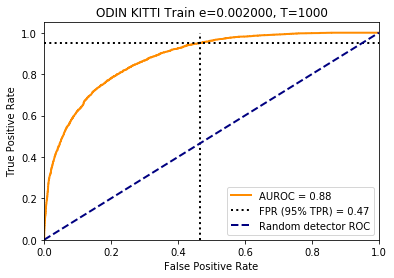

{'fpr_at_95_tpr': 0.4657536432294437, 'detection_error': 0.2578394306271936, 'auroc': 0.8781391418465395, 'aupr_in': 0.7460000734192636, 'aupr_out': 0.9478839552736762}


In [42]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:# and not os.path.exists(save_file):
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)

kitti_train_X, kitti_train_y = read_scores(save_file)
kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="ODIN KITTI Train e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val


ODIN Kitti Val e=0.002000, T=1000


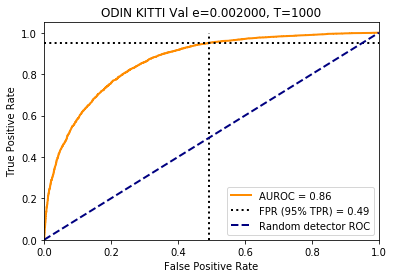

{'fpr_at_95_tpr': 0.4913499179189292, 'detection_error': 0.2706385158107766, 'auroc': 0.8635518627561789, 'aupr_in': 0.8051941852711608, 'aupr_out': 0.898603834019615}


In [43]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:# and not os.path.exists(save_file):
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
kitti_val_X, kitti_val_y = read_scores(save_file)
kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="ODIN KITTI Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

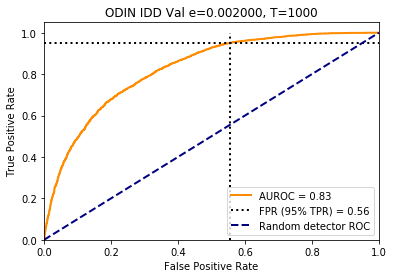

{'fpr_at_95_tpr': 0.5557986870897156, 'detection_error': 0.30286216487479195, 'auroc': 0.8255278400069505, 'aupr_in': 0.8253553488760216, 'aupr_out': 0.8198700095614315}


In [44]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:# and not os.path.exists(save_file):
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

idd_val_X, idd_val_y = read_scores(save_file)
idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## Entropy

In [47]:
NUM_MC_PASSES = 10

def extract_kitti_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    model.train()
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()
      
        
def extract_idd_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()

import mc_uncertainty as mcu


def read_mc_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]

            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=-1)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return np.moveaxis(np.stack((X, 1-X)), 0, 2), y

#### Kitti Val

In [46]:
if False:
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
    extract_kitti_mc_softmax(kitti_val_dataset, trainer.faster_rcnn, save_file)

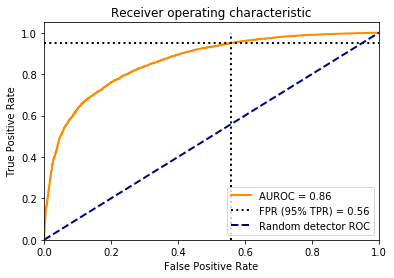

{'fpr_at_95_tpr': 0.5576923076923077, 'detection_error': 0.30383359734188464, 'auroc': 0.8628160743492235, 'aupr_in': 0.8982402214760286, 'aupr_out': 0.8072416360709921}


In [48]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

In [49]:
if False:
    save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
    extract_idd_mc_softmax(idd_val_dataset, trainer.faster_rcnn, save_file)


(10, 8878, 2)


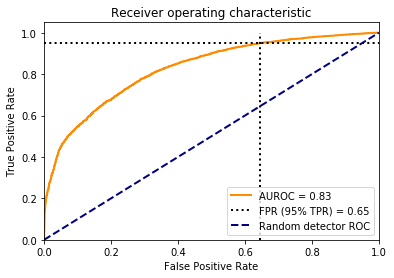

{'fpr_at_95_tpr': 0.6460344104070499, 'detection_error': 0.3479442480050814, 'auroc': 0.8274432905502825, 'aupr_in': 0.8198573114054868, 'aupr_out': 0.8312472708391049}


In [50]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)
print(X.shape)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

## Mutual Information

#### Kitti Val

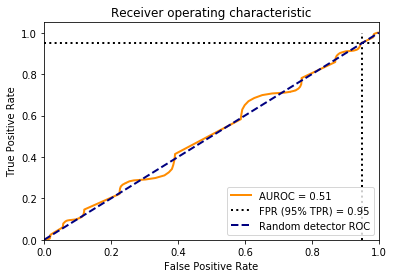

{'fpr_at_95_tpr': 0.9485221978021977, 'detection_error': 0.49586550650086564, 'auroc': 0.505731308286557, 'aupr_in': 0.5977703924388346, 'aupr_out': 0.414163401580222}


In [51]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

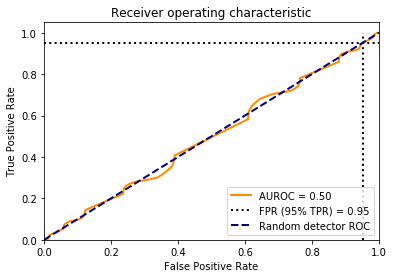

{'fpr_at_95_tpr': 0.9528211192919543, 'detection_error': 0.49758227865669763, 'auroc': 0.4984662047642918, 'aupr_in': 0.4636930558967389, 'aupr_out': 0.5358700688836592}


In [52]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

# Vahdats Extended Feature Extractor Set

### Bind a feature extractor function to the model

In [53]:
model = trainer.faster_rcnn

@nograd
def get_all_features(self, imgs, visualize=False):
    self.eval()
    if visualize:
        prepared_imgs = list()
        for img in imgs:
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
    else:
         prepared_imgs = imgs 

    for img in prepared_imgs:
        img = at.totensor(img[None], cuda=True).float()
        features = [img]
        
        for l in self.extractor:
            features.append(l(features[-1]))
        
        # Detach all features from GPU
        features = [at.tonumpy(f) for f in features]
        # Remove the first feature (ie the image)
        features = features[1:]
        # Average the features over the final two dimensions
        features = [np.mean(f, axis=(2,3)).squeeze(axis=0) for f in features]
        return features
    
model.get_all_features = get_all_features.__get__(model)

### Get the GT features

In [54]:
def extract_extended_kitti_features_gt(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            cars_bboxes = gt_bboxes[gt_labels == 0]
            
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(cars_bboxes):
                d_car = d.create_group("gt_bbox_"+str(j))
                y1, x1, y2, x2 = box.type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]
                
                # Check correct sections of image are extracted
                # plt.imshow(np.moveaxis(np.squeeze(at.tonumpy(im), axis=0), 0, 2).astype(np.int))
                # plt.show()
                
                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_car.create_dataset("extended_feat_"+str(k), data=feats)

if True:
    extract_extended_kitti_features_gt(kitti_train_dataset, trainer.faster_rcnn, os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5"))

In [55]:
def extract_extended_kitti_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
                    
def extract_extended_idd_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
if True:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_path)

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    extract_extended_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tad

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=sil

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<ipython-input-55-20fdcebb8c65>", line 119, in <module>
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "<ipython-input-55-20fdcebb8c65>", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-55-20fdcebb8c65>", line 119, in <module>
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _lau

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=s

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 215, in <module>
    class PngInfo(object):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 294, in <module>
    class PngStream(ChunkStream):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 318, in PngStream
    def chunk_iCCP(self, pos, length):
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyt

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/h

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2808, in open
    im = _open_core(fp, filename, prefix)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2794, in _open_core
    im = factory(fp, filename)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImageFile.py", line 105, in __init__
    self._open()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 588, in _open
    s = self.png.call(cid, pos, length)
  File "/home/t

--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent cal

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 29

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/abc.py", line 139, in __instancecheck__
    return _abc_instancecheck(cls, instance)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/abc.py", line 143, in __subclasscheck__
    return _abc_subclasscheck(cls, subclass)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  Fil

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tade

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pack

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_contex

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/xml/etree/ElementTree.py", line 598, in parse
    self._root = parser._parse_whole(source)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._po

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '062aafd4-beef291f105e95767ba04eca', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '2d6c3feb-b4c08ed0ae495a4550621ced', 'date': datetime.datetime(2019, 12, 27, 19, 26, 5, 631210, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '062aafd4-beef291f105e95767ba04eca', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'ecb1d4e74d7a4b9b8978531f13f57397', 'username': 'username', 'session': 'd37dcf210c3949a381d6f21f798700a3', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 27, 14, 16, 32, 629301, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
  

### Train SVM classifiers

In [56]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
SUBSET_KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

def read_gt_extended_features(file, feature_idx):
    features = None
    
    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            for gt_bbox in im.keys():
                gt_bbox = im[gt_bbox]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features


def read_extended_features(file, feature_idx):
    features = None
    labels = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            # Get the correctness labels
            label_is_car = im['pred']["pred_labels"][()] == 0
            iou_is_high_enough = im['pred']["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            labs = 1 - (label_is_car & iou_is_high_enough & classification_is_correct)
            labels = np.concatenate((labels, labs), axis=0)

            # Get the required features
            for j in im['bboxes'].keys():
                gt_bbox = im['bboxes'][j]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features, labels

# Train all the classifiers
def train_osvm(nu, gamma, kernel, train_features, one_class_save_path):
        # Train one class SVM
        clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        clf.fit(train_features)

        # Save classifier
        with open(one_class_save_path, 'wb') as f:
            pickle.dump(clf, f)

NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

if True:
    for i in trange(NUM_EXTENDED_FEATURES):
        features_gt = read_gt_extended_features(GT_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            train_osvm(nu, gamma, kernel, features_gt, save_path)

### Determine best params/OODL

In [58]:
if True:
    kitti_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):

        # Load the kitti val features
        kitti_val_X, kitti_val_y = read_extended_features(SUBSET_KITTI_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
            res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            kitti_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'wb') as f:
        pickle.dump(kitti_val_results, f)

else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

In [59]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])

print(best_params)
print(kitti_val_results[best_params])

188
{'fpr_at_95_tpr': 0.8403575989782887, 'detection_error': 0.44503539604746173, 'auroc': 0.6416464595405718, 'aupr_in': 0.5186538573338568, 'aupr_out': 0.7263092958092058, 'nu': 0.01, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_cars_drop_checkpoints_with_nms/one_class_models/kitti-one-class-extended-feat23-nu0.0100-gammaauto-kernelrbf.pickle'}


In [60]:
oodl, (nu, gamma, kernel) = list(itertools.product(list(range(NUM_EXTENDED_FEATURES)), train_args))[best_params]

In [61]:
# Load the best classifier
save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
with open(save_path, 'rb') as f:
    clf = pickle.load(f)

### Kitti Val

In [62]:
kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

{'fpr_at_95_tpr': 0.9987443495730789, 'detection_error': 0.5, 'auroc': 0.260421553584537, 'aupr_in': 0.2981986303036866, 'aupr_out': 0.44376905179172227, 'nu': 0.01, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_cars_drop_checkpoints_with_nms/one_class_models/kitti-one-class-extended-feat29-nu0.0100-gammaauto-kernelrbf.pickle'}


### IDD VAL

In [63]:
idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
idd_val_novelty_scores = -clf.decision_function(idd_val_X)
res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

{'fpr_at_95_tpr': 0.9730058365758755, 'detection_error': 0.5, 'auroc': 0.4717861073329077, 'aupr_in': 0.5263590488524917, 'aupr_out': 0.4316095373775326, 'nu': 0.01, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_cars_drop_checkpoints_with_nms/one_class_models/kitti-one-class-extended-feat29-nu0.0100-gammaauto-kernelrbf.pickle'}


## Mahalanobis with input perturbation

In [9]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

Build a Mahalanobis model for each of train eps and temp

In [10]:
if True:
    for eps, temp in tqdm(odin_params, total=len(odin_params)):
        save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))
        kitti_train_X, kitti_train_y = read_features(save_file, 4)

        mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    
        # Take features from good detections only
        kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]

        # Everything is labelled 0 because we're just doing single class detection
        kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))

        md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
        md.save(mahal_model_name)


Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Get the best model based on the Kitti Val performance

In [12]:
results2 = []
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    # Get the data
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    kitti_val_X, kitti_val_y = read_features(save_path, 4)
    
    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)
    
    kitti_val_novelty_scores = md(kitti_val_X)
    results2.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

In [13]:
# Pick the best eps and temp

idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
print(odin_params[1:][idx])

eps, temp = odin_params[1:][idx]

# Load the model
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
md = Mahal_Dist.load(mahal_model_name)

(0.0002, 1000)


#### Kitti Val

In [14]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
kitti_val_X, kitti_val_y = read_features(save_path, 4)

l = len(kitti_val_X)
chunk = 10000
kitti_val_novelty_scores = [md(kitti_val_X[i:i+chunk]) for i in range(0,l,chunk)]
kitti_val_novelty_scores = np.concatenate(kitti_val_novelty_scores, axis=0)

kitti_val_novelty_scores = md(kitti_val_X)
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

MemoryError: 

#### IDD Val

In [ ]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
idd_val_X, idd_val_y = read_features(save_path, 4)

idd_val_novelty_scores = md(idd_val_X)
plot_roc(idd_val_novelty_scores, 1 - idd_val_y)
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

### TODO:

#### Code

1. Train multiple class model
    1. Different anchor boxes
    - Scale == 1500?
    - See "A closer look at Faster R-CNN for vehicle detection"

1. Repeat all experiments with multiple class object detector


1. Example images of poor detections

1. Risk-Coverage plots
1. AP with each method
1. Runtime statistics for a single prediction for each method


1. Rerun experiments for False positive detection

1. More correct Mahalanobis with input perturbation?


#### Other stuff

1. Remove Steve as co-supervisor
1. Email grad director for two-week display period
1. Agreement to read form

#### Writing

1. Finish results
1. Finish experimental setup
1. Write conclusion/discussion
1. Add more background on AnDet techniques
1. Rewrite intro sections
1. Edit edit edit